In [4]:
import pandas as pd
import numpy as np
from pyarrow import Table
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from source import *
from pathlib import Path

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import scienceplots

plt.style.use(['science','ieee', 'grid'])
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [138]:
sig = ds.dataset(list(Path(f"sig_data/").glob("*.parquet")), format="parquet")
sig = get_values(sig, ['pmiss', 'thetamiss', 'missedE', 'fox', "p_tau_0", "p_tau_1", 'dr0', 'dr1'], filter_mask=(((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1)) & (pc.field("E_gamma_in_ROE") < 0.2) & (pc.field("is0") == 1)), )
lep = ds.dataset(list(Path(f"halfleptonic/").glob("*.parquet")), format="parquet")
lep = get_values(lep, ['pmiss', 'thetamiss', 'missedE', 'fox', "p_tau_0", "p_tau_1", 'dr0', 'dr1'], filter_mask=(((pc.field("idec0") == 0) | (pc.field("idec0") == 1)) & ((pc.field("idec1") == 0) | (pc.field("idec1") == 1)) & (pc.field("E_gamma_in_ROE") < 0.2) & (pc.field("is0") == 1)), )


Total data size: 3.47 MB
Total data size: 0.14 MB


In [139]:
lep["label"] = 0  # Класс 0
sig["label"] = 1  # Класс 1
df = pd.concat([sig, lep], ignore_index=True)

In [140]:
X = df.drop(columns=["label"])
y = df["label"]

In [141]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [142]:
def gini_eval(preds, dtrain):
    labels = dtrain.get_label()
    from sklearn.metrics import roc_auc_score
    auc = roc_auc_score(labels, preds)
    gini = 2 * auc - 1
    return 'gini', gini

In [143]:

w_train = np.where(y_train == 0, 1.0, len(lep) / len(sig))

model = XGBClassifier(
    max_depth=4,
    n_estimators=3000,
    learning_rate=0.02,
    subsample=0.7,
    colsample_bytree=0.9,
    feval=gini_eval,
    random_state=42,
)
model.fit(X_train, y_train, sample_weight=w_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [144]:

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.14      0.55      0.22       811
           1       0.98      0.86      0.92     20388

    accuracy                           0.85     21199
   macro avg       0.56      0.71      0.57     21199
weighted avg       0.95      0.85      0.89     21199

ROC AUC: 0.7838314927157897
Confusion Matrix:
 [[  450   361]
 [ 2812 17576]]


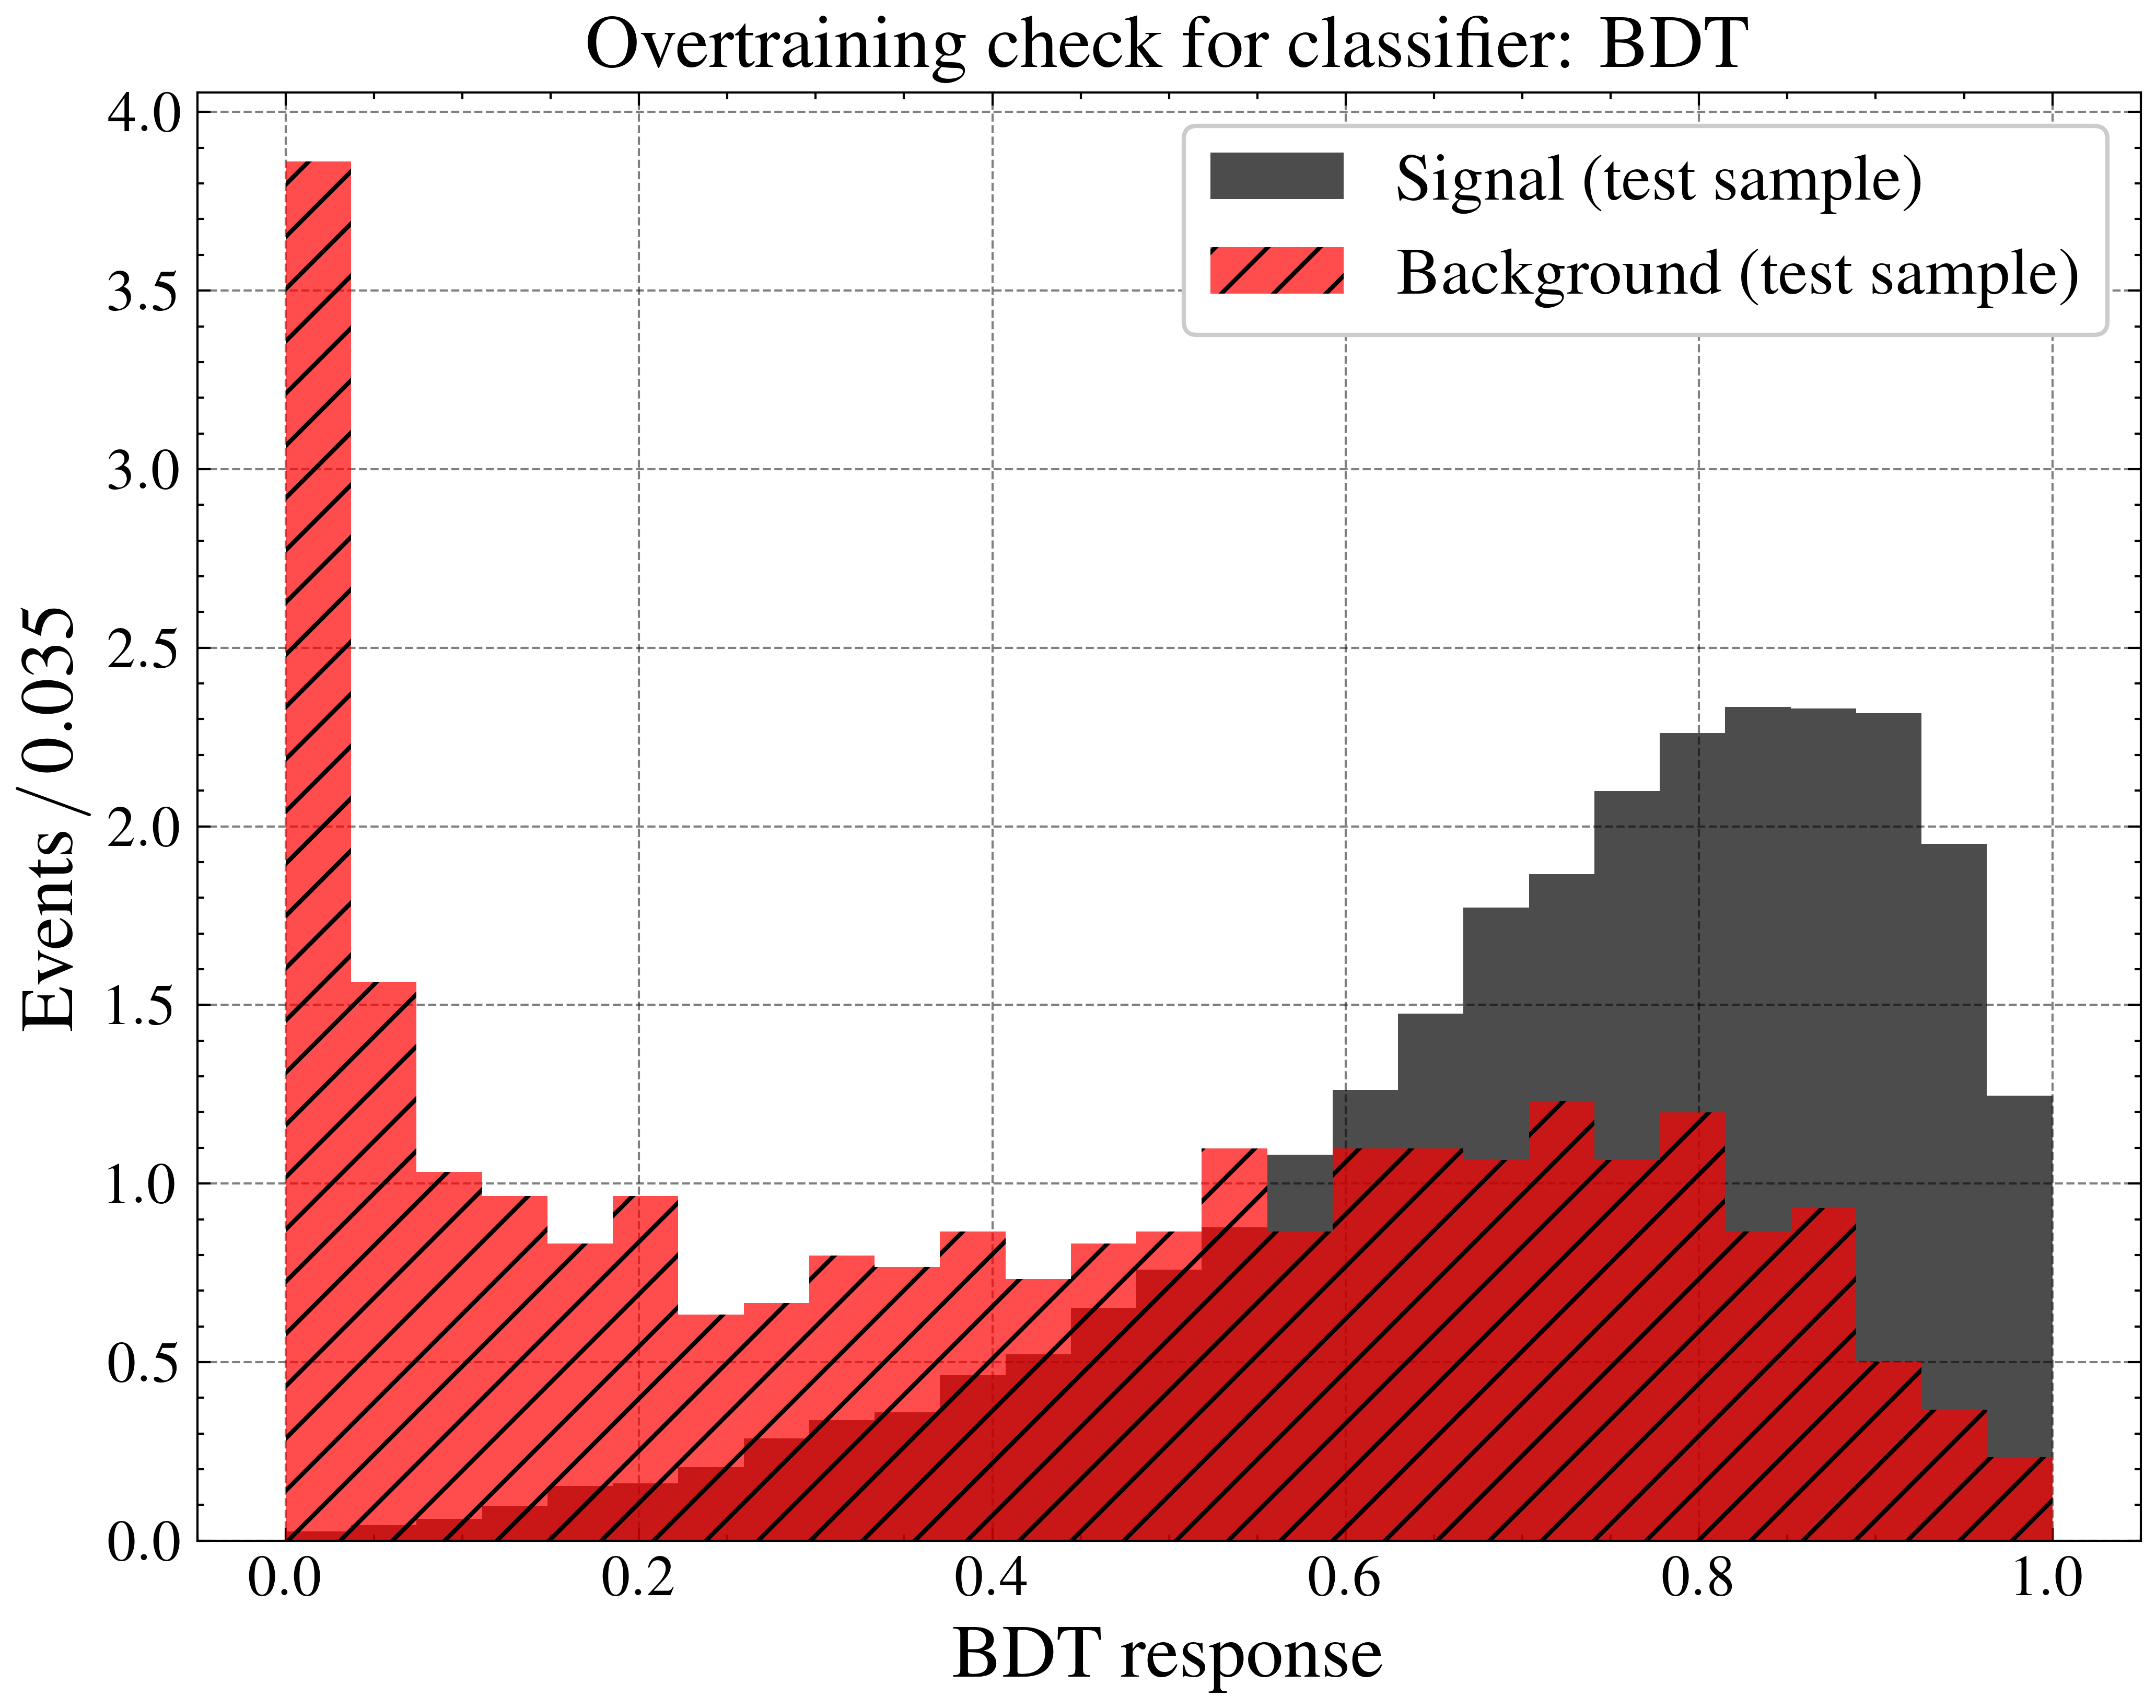

In [145]:
wbin = 0.035
a = 0
b = 1
bins = np.linspace(a, b, int((b-a)/wbin))


train_pred = model.predict_proba(X_train)[:, 1]
test_pred = model.predict_proba(X_test)[:, 1]

# Выбираем маски
sig_train = train_pred[y_train == 1]
bkg_train = train_pred[y_train == 0]
sig_test = test_pred[y_test == 1]
bkg_test = test_pred[y_test == 0]

# === График ===
plt.figure(figsize=(8, 6))


# Гистограммы
plt.hist(sig_test, bins=bins, density=True, alpha=0.7, label="Signal (test sample)")

plt.hist(bkg_test, bins=bins, density=True, alpha=0.7, label="Background (test sample)", hatch="//")

# === Подписи ===
plt.xlabel("BDT response")
plt.ylabel(f'$\\mathrm{{Events}}\\,/\\,{wbin}$')
plt.title("Overtraining check for classifier: BDT")
plt.legend(loc='best')

In [146]:
import xgboost as xgb

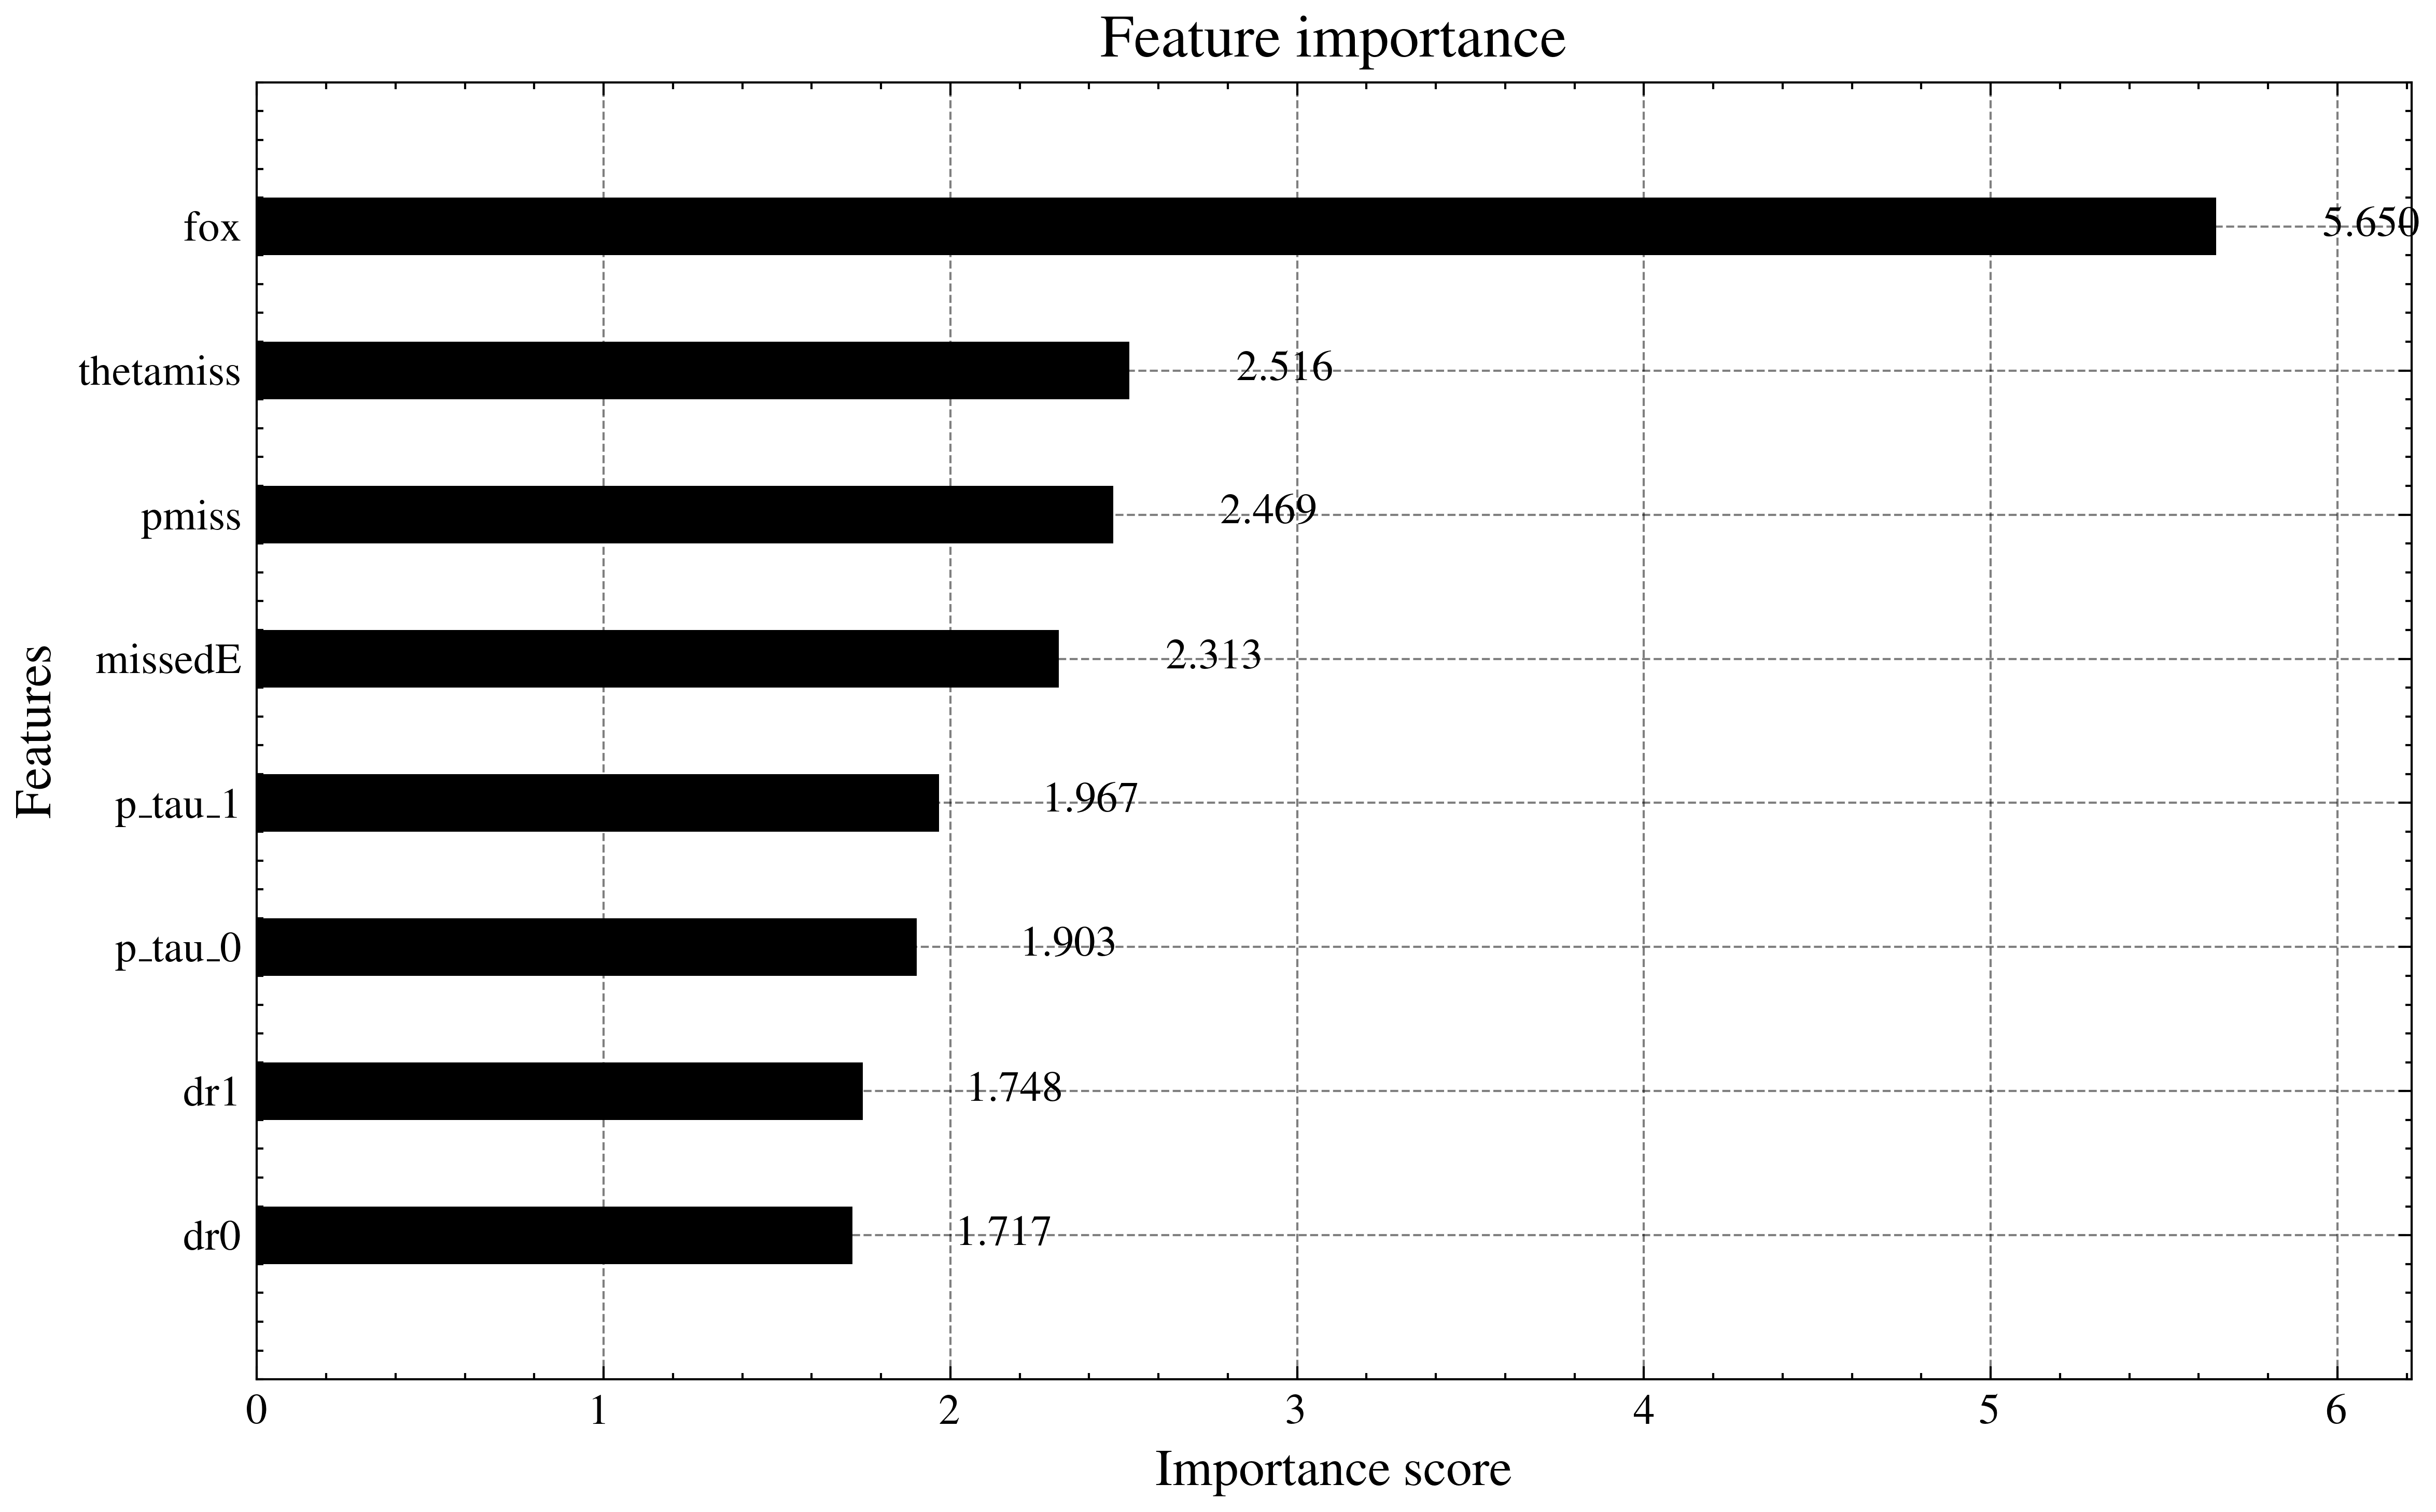

In [147]:
fig, ax = plt.subplots(figsize=(8, 5)) 

xgb.plot_importance(
    model,
    ax=ax,
    importance_type='gain',
    max_num_features=15,
    height=0.4,
    show_values=False, 
    grid=True
)

for rect in ax.patches:
    width = rect.get_width()
    y = rect.get_y() + rect.get_height() / 2
    ax.text(
        width + 0.05 * ax.get_xlim()[1],  
        y,
        f"{width:.3f}",
        va='center',
        ha='left',
        fontsize=10
    )

ax.set_title("Feature importance", fontsize=14)
ax.set_xlabel("Importance score", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.show()